# Encode & Decode for single block

In [1]:
import numpy as np
import sys
import cv2
import scipy.fftpack as fft
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Frame:
    def __init__(self, image, QF=1):
        '''
        @param image: RBG image of shape (height, width, 3)
        '''
        self.QF=QF
        self.image = image
        self.r = image[:, :, 0]
        self.g = image[:, :, 1]
        self.b = image[:, :, 2]
        self.v_mblocks = np.shape(self.r)[0] // 16
        self.h_mblocks = np.shape(self.r)[1] // 16

    def getFrame(self):
        reconstructed_image = np.dstack((self.r, self.g, self.b))
        return reconstructed_image
        
    def show(self):
        self.getFrame()
        plt.imshow(self.getFrame())
    
    def getBlock(self,m,n):
        m_start = m*16
        n_start = n*16
        tmp = self.image[m_start:m_start+16,n_start:n_start+16]
        #plt.imshow(tmp)
        return tmp
    '''
    def image_to_blocks(self):
        """
        Convert the stored image into a sequence of 8x8 pixel blocks for encoding
        :return: (x, 8, 8) shaped array. x depends on dimensions of original image
        """
        return proto_mpeg_computation.image_to_blocks(self.r, self.g, self.b)'''


In [3]:
img_name = './code/pics/baboon.jpg'
#img_name = 'cameraman.png'
src = plt.imread(img_name)[:16,:16]
src.shape

(16, 16, 3)

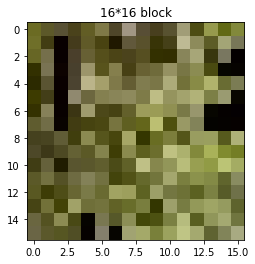

In [4]:
plt.title('16*16 block')
plt.imshow(src)

In [5]:
# Split bgr color channels
blue,green,red = cv2.split(src)
gray = cv2.cvtColor(src , cv2.COLOR_BGR2GRAY) # Convert color form BGR to Gray

In [6]:
# Convert color form BGR to Y_Cr_Cb
YCrCb = cv2.cvtColor(src , cv2.COLOR_RGB2YCR_CB)
# Split Y_Cb_Cr channelsx
Y,Cb,Cr = cv2.split(YCrCb)

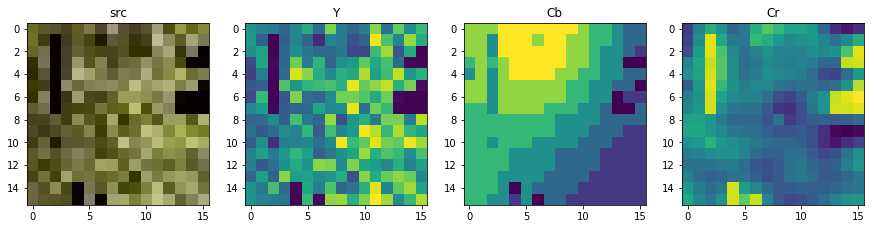

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(141)
plt.title('src')
plt.imshow(src)
plt.subplot(142)
plt.title('Y')
plt.imshow(Y)
plt.subplot(143)
plt.title('Cb')
plt.imshow(Cb)
plt.subplot(144)
plt.title('Cr')
plt.imshow(Cr)

In [8]:
# Note: This is an old version of subsampling. Keep the top left pixel for each 2x2 block
def subsample_topleft(src):
    tmp = []
    for i in range(0,len(src),2):
        #print(i)
        #print(Cb[i])
        #print(Cb[i][::2])
        tmp.append(src[i][::2])
        #print(tmp)
    tmp = np.array(tmp)
    return tmp

In [9]:
# Compute each mean of 2x2 block, return 8*8 subsampled blcok
def subsample(src):
    #print(src)
    tmp = []
    #print()
    for i in range(0,len(src),2):
        #print(i)
        for j in range(0,len(src),2):
            #print(np.mean([src[i][j],src[i][j+1],src[i+1][j],src[i+1][j+1]]))
            tmp.append(np.mean([src[i][j],src[i][j+1],src[i+1][j],src[i+1][j+1]]))
    tmp = np.array(tmp)
    tmp = tmp.reshape(8,8).astype(np.uint8)
    return tmp

In [10]:
Y1 = Y[:8,:8]
Y2 = Y[:8,8:]
Y3 = Y[8:,:8]
Y4 = Y[8:,8:]
subsample_Cb = subsample(Cb)
subsample_Cr = subsample(Cr)

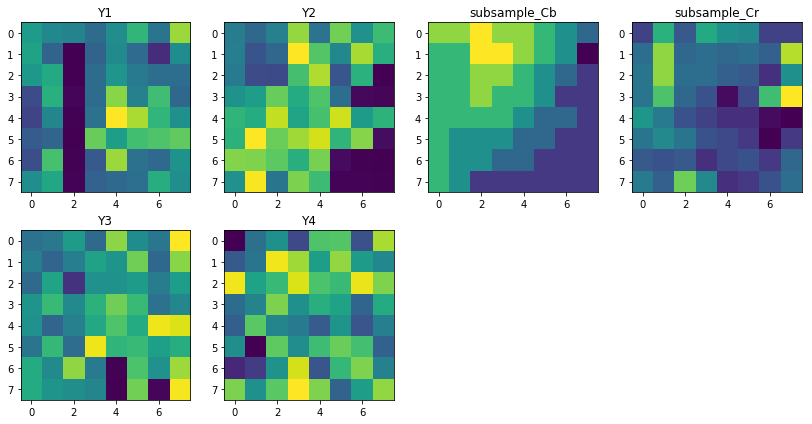

In [11]:
plt.figure(figsize=(14,7))
plt.subplot(241)
plt.title('Y1')
plt.imshow(Y1)
plt.subplot(242)
plt.title('Y2')
plt.imshow(Y2)
plt.subplot(243)
plt.title('subsample_Cb')
plt.imshow(subsample_Cb)
plt.subplot(244)
plt.title('subsample_Cr')
plt.imshow(subsample_Cr)
plt.subplot(245)
plt.title('Y3')
plt.imshow(Y3)
plt.subplot(246)
plt.title('Y4')
plt.imshow(Y4)

In [12]:
def dct(y):
    F = fft.dct(fft.dct(y, axis=0, norm='ortho', type=2), axis=1, norm='ortho', type=2)
    #F[0,0]=F[0,0]/64.
    return F
def idct(y):
    #F[0,0]=F[0,0]*64
    return fft.idct(fft.idct(y, axis=0, norm='ortho', type=2), axis=1, norm='ortho', type=2)

In [13]:
dct2_Y1 = dct(Y1)
dct2_Y2 = dct(Y2)
dct2_Y3 = dct(Y3)
dct2_Y4 = dct(Y4)
dct2_Cb = dct(subsample_Cb)
dct2_Cr = dct(subsample_Cr)

In [14]:
dct2_Y1

array([[  6.34750000e+02,  -1.05072446e+02,   1.80282827e+01,
          1.14157685e+02,   6.37500000e+01,  -9.89633502e+01,
         -1.05424053e+02,  -4.61782904e+01],
       [ -7.33721362e+00,   4.04628624e+01,   1.61860407e+01,
         -7.33341265e+00,   1.87371654e+01,  -1.03390890e-01,
          6.87206462e+01,   6.72062944e+00],
       [ -1.99970592e+01,   5.10414231e+01,   7.36984848e+01,
         -4.85030607e+01,   1.42544747e+01,   6.80805578e+00,
          5.58657467e+01,  -7.03498967e+00],
       [  6.76829664e+01,  -7.54930828e+01,  -3.28450738e+01,
         -1.79733745e+01,   1.21277633e+01,   1.57310029e-01,
          5.02164909e+01,  -1.40571287e+01],
       [  3.92500000e+01,  -2.64059133e+01,   2.70598050e-01,
          8.15210311e+00,  -4.62500000e+01,  -1.78724158e-01,
         -6.53281482e-01,   2.60262179e+01],
       [  1.66958340e+01,   1.57703321e+01,  -7.27960309e+00,
         -2.36386315e+01,  -1.89997438e+01,  -3.66631875e+01,
         -2.78879718e+01,   2.1

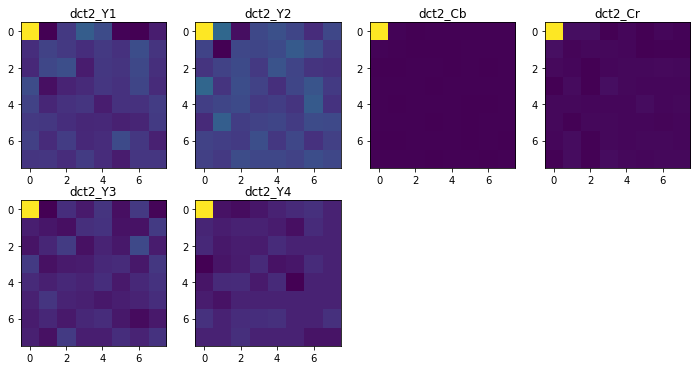

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(241)
plt.title('dct2_Y1')
plt.imshow(dct2_Y1)
plt.subplot(242)
plt.title('dct2_Y2')
plt.imshow(dct2_Y2)
plt.subplot(243)
plt.title('dct2_Cb')
plt.imshow(dct2_Cb)
plt.subplot(244)
plt.title('dct2_Cr')
plt.imshow(dct2_Cr)
plt.subplot(245)
plt.title('dct2_Y3')
plt.imshow(dct2_Y3)
plt.subplot(246)
plt.title('dct2_Y4')
plt.imshow(dct2_Y4)

In [16]:
# Define quantization matrix
# Source: https://en.wikipedia.org/wiki/MPEG-1#Quantization
quantization_matrix = np.matrix('16 11 10 16 24 40 51 61;12 12 14 19 26 58 60 55;14 13 16 24 40 57 69 56;14 17 22 29 51 87 80 62;18 22 37 56 68 109 103 77;24 35 55 64 81 104 113 92;49 64 78 87 103 121 120 101;72 92 95 98 112 100 103 99')
quantization_matrix

matrix([[ 16,  11,  10,  16,  24,  40,  51,  61],
        [ 12,  12,  14,  19,  26,  58,  60,  55],
        [ 14,  13,  16,  24,  40,  57,  69,  56],
        [ 14,  17,  22,  29,  51,  87,  80,  62],
        [ 18,  22,  37,  56,  68, 109, 103,  77],
        [ 24,  35,  55,  64,  81, 104, 113,  92],
        [ 49,  64,  78,  87, 103, 121, 120, 101],
        [ 72,  92,  95,  98, 112, 100, 103,  99]])

In [17]:
# Quantization function
def quantize(F,QF):
    quant_matrix=np.ceil(quantization_matrix*QF)
    #print(quant_matrix)
    quant_matrix[quant_matrix>255]=255
    #print(F,quant_matrix)
    return (F/quant_matrix).astype(np.int)

In [18]:
# manual way
def quantize1(F,QF):
    quant_matrix=np.ceil(quantization_matrix*QF)
    quant_matrix[quant_matrix>255]=255
    tmp = []
    for i in range(8):
        for j in range(8):
            #print(quant_matrix.A[i][j])
            tmp.append(int(round(F[i][j]/quant_matrix.A[i][j])))
    print(np.array(tmp).reshape(8,8))

In [19]:
QF = 0.1 ######## CHANGE THIS TO CONTROL QUALITY. Recommend [0.1, 2]#######
qtz_Y1 = quantize(dct2_Y1,QF) 
qtz_Y2 = quantize(dct2_Y2,QF) 
qtz_Y3 = quantize(dct2_Y3,QF) 
qtz_Y4 = quantize(dct2_Y4,QF) 
qtz_Cb = quantize(dct2_Cb,QF) 
qtz_Cr = quantize(dct2_Cr,QF) 

In [20]:
print(dct2_Y1)

[[  6.34750000e+02  -1.05072446e+02   1.80282827e+01   1.14157685e+02
    6.37500000e+01  -9.89633502e+01  -1.05424053e+02  -4.61782904e+01]
 [ -7.33721362e+00   4.04628624e+01   1.61860407e+01  -7.33341265e+00
    1.87371654e+01  -1.03390890e-01   6.87206462e+01   6.72062944e+00]
 [ -1.99970592e+01   5.10414231e+01   7.36984848e+01  -4.85030607e+01
    1.42544747e+01   6.80805578e+00   5.58657467e+01  -7.03498967e+00]
 [  6.76829664e+01  -7.54930828e+01  -3.28450738e+01  -1.79733745e+01
    1.21277633e+01   1.57310029e-01   5.02164909e+01  -1.40571287e+01]
 [  3.92500000e+01  -2.64059133e+01   2.70598050e-01   8.15210311e+00
   -4.62500000e+01  -1.78724158e-01  -6.53281482e-01   2.60262179e+01]
 [  1.66958340e+01   1.57703321e+01  -7.27960309e+00  -2.36386315e+01
   -1.89997438e+01  -3.66631875e+01  -2.78879718e+01   2.14229165e+01]
 [  3.53428581e+01  -1.53115910e+01   2.68657467e+01  -2.00273028e+01
   -1.13163577e+01   5.94543034e+01   1.43015152e+01  -3.66815166e+01]
 [  8.9613328

In [21]:
qtz_Cb

matrix([[528,   4,  -3,   0,   0,   0,   0,   0],
        [  3,   0,  -2,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]])

In [22]:
# takes a series of integers, returns the number of prefix 0s
def prefix_0(s):
    if len(s)==0:
        return 0
    i=0
    count = 0
    while s[i]==0 :
        count+=1
        #print(i,len(s)-1)
        if i==len(s)-1:
            return count
        i+=1
    return count

In [23]:
# This is an array of indices that we use to sample a flattened DCT array in zigzag order.
zz_indices = [ 0,  1,  8, 16,  9,  2,  3, 10,
               17, 24, 32, 25, 18, 11, 4,  5,
               12, 19, 26, 33, 40, 48, 41, 34,
               27, 20, 13,  6,  7, 14, 21, 28,
               35, 42, 49, 56, 57, 50, 43, 36,
               29, 22, 15, 23, 30, 37, 44, 51,
               58, 59, 52, 45, 38, 31, 39, 46,
               53, 60, 61, 54, 47, 55, 62, 63]

In [24]:
# convert the flattened list to the zigzaged order
zz_series = [qtz_Y1.A1[i] for i in zz_indices]
print(len(zz_series))
print(zz_series)

64
[317, -52, -3, -9, 20, 18, 57, 8, 25, 33, 19, -37, 36, -3, 21, -24, 6, -16, -10, -8, 5, 7, 3, 0, -5, 3, 0, -17, -6, 11, 1, 2, 1, -1, -2, 1, 1, 3, -3, -6, 0, 7, 1, -1, 6, 0, -2, -2, -1, 2, -1, -3, 0, -2, 3, -2, 4, -1, -4, 1, 2, -3, 1, 1]


In [25]:
# process the middle part -- <run, level>
# takes a list of numbers
# return a list of <run, level> pair
def run_level(tmp):
    encoded_string = []
    while True:
        #print(tmp)
        a = prefix_0(tmp)
        #print(a,len(tmp))
        if a==len(tmp):
            break
        #print([a,tmp[a]])
        encoded_string.append([a,tmp[a]])
        tmp = tmp[a+1:]
    return encoded_string

In [26]:
# takes a zigzag series of coeffs
# returns a list, in the form <DC term> <run, level> <EOB>
def zigzag_from_flattened_block(tmp):
    encoded_string = [tmp[0]]
    encoded_string += run_level(tmp[1:])
    encoded_string.append('EOB')
    return encoded_string

In [27]:
# takes a list, in the form <DC term> <run, level> <EOB>
# returns a zigzag series of coeffs
def zigzag_to_flattened_block(encoded_string):
    rst = [encoded_string[0]]
    for i in encoded_string[1:-1]:
        #print(i)
        for _ in range(i[0]):
            rst.append(0)
        rst.append(i[1])
    #print(16-len(rst))
    for i in range(64-len(rst)):
        rst.append(0)
    return rst

In [28]:
# a simple example of encoding and decoding
tmp = [1,2,0,0,1,0,0,0,2,0,3,0,0,0,0,0]
encoded = zigzag_from_flattened_block(tmp)
decoded = zigzag_to_flattened_block(encoded)
print(tmp)
print(encoded)
print(decoded) #decoded list has extra zeros because it only works for 8x8 blocks, but this example has less elements.

[1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0]
[1, [0, 2], [2, 1], [3, 2], [1, 3], 'EOB']
[1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
# encoding and decoding Y1
print(zz_series,len(zz_series),"\n")
encoded = zigzag_from_flattened_block(zz_series)
print(encoded,"\n")
decoded = zigzag_to_flattened_block(encoded)
print(decoded,len(decoded))

[317, -52, -3, -9, 20, 18, 57, 8, 25, 33, 19, -37, 36, -3, 21, -24, 6, -16, -10, -8, 5, 7, 3, 0, -5, 3, 0, -17, -6, 11, 1, 2, 1, -1, -2, 1, 1, 3, -3, -6, 0, 7, 1, -1, 6, 0, -2, -2, -1, 2, -1, -3, 0, -2, 3, -2, 4, -1, -4, 1, 2, -3, 1, 1] 64 

[317, [0, -52], [0, -3], [0, -9], [0, 20], [0, 18], [0, 57], [0, 8], [0, 25], [0, 33], [0, 19], [0, -37], [0, 36], [0, -3], [0, 21], [0, -24], [0, 6], [0, -16], [0, -10], [0, -8], [0, 5], [0, 7], [0, 3], [1, -5], [0, 3], [1, -17], [0, -6], [0, 11], [0, 1], [0, 2], [0, 1], [0, -1], [0, -2], [0, 1], [0, 1], [0, 3], [0, -3], [0, -6], [1, 7], [0, 1], [0, -1], [0, 6], [1, -2], [0, -2], [0, -1], [0, 2], [0, -1], [0, -3], [1, -2], [0, 3], [0, -2], [0, 4], [0, -1], [0, -4], [0, 1], [0, 2], [0, -3], [0, 1], [0, 1], 'EOB'] 

[317, -52, -3, -9, 20, 18, 57, 8, 25, 33, 19, -37, 36, -3, 21, -24, 6, -16, -10, -8, 5, 7, 3, 0, -5, 3, 0, -17, -6, 11, 1, 2, 1, -1, -2, 1, 1, 3, -3, -6, 0, 7, 1, -1, 6, 0, -2, -2, -1, 2, -1, -3, 0, -2, 3, -2, 4, -1, -4, 1, 2, -3, 1, 1] 

In [30]:
reversed_zz_indices = [0, 1, 5, 6, 14,15,27,28,
                       2, 4, 7, 13,16,26,29,42,
                       3, 8, 12,17,25,30,41,43,
                       9, 11,18,24,31,40,44,53,
                       10,19,23,32,39,45,52,54,
                       20,22,33,38,46,51,55,60,
                       21,34,37,47,50,56,59,61,
                       35,36,48,49,57,58,62,63]

In [31]:
qtz_Y1

matrix([[317, -52,  18,  57,  21, -24, -17,  -6],
        [ -3,  20,   8,  -3,   6,   0,  11,   1],
        [ -9,  25,  36, -16,   3,   1,   7,  -1],
        [ 33, -37, -10,  -5,   2,   0,   6,  -2],
        [ 19,  -8,   0,   1,  -6,   0,   0,   3],
        [  5,   3,  -1,  -3,  -2,  -3,  -2,   2],
        [  7,  -2,   3,  -2,  -1,   4,   1,  -3],
        [  1,   1,  -1,   2,  -1,  -4,   1,   1]])

In [32]:
de_flattened = np.array([decoded[i] for i in reversed_zz_indices]).reshape(8,8)

In [33]:
### not correct. don't know why ###
def de_quantize(F):
    quant_matrix=np.ceil(quantization_matrix*QF)
    #print(quant_matrix)
    quant_matrix[quant_matrix>255]=255
    print(quant_matrix)
    print(F)
    return (F*quant_matrix).astype(np.int)

In [34]:
# manual way
def de_quantize1(F,QF):
    quant_matrix=np.ceil(quantization_matrix*QF)
    quant_matrix[quant_matrix>255]=255
    tmp = []
    for i in range(8):
        for j in range(8):
            #tmp1 = F[i][j]*quant_matrix.A[i][j]
            #print(tmp1)
            tmp.append(int(F[i][j]*quant_matrix.A[i][j]))
    return np.array(tmp).reshape(8,8)

In [35]:
de_flattened

array([[317, -52,  18,  57,  21, -24, -17,  -6],
       [ -3,  20,   8,  -3,   6,   0,  11,   1],
       [ -9,  25,  36, -16,   3,   1,   7,  -1],
       [ 33, -37, -10,  -5,   2,   0,   6,  -2],
       [ 19,  -8,   0,   1,  -6,   0,   0,   3],
       [  5,   3,  -1,  -3,  -2,  -3,  -2,   2],
       [  7,  -2,   3,  -2,  -1,   4,   1,  -3],
       [  1,   1,  -1,   2,  -1,  -4,   1,   1]])

In [36]:
de_quantized = de_quantize1(de_flattened,QF)
de_quantized

array([[ 634, -104,   18,  114,   63,  -96, -102,  -42],
       [  -6,   40,   16,   -6,   18,    0,   66,    6],
       [ -18,   50,   72,  -48,   12,    6,   49,   -6],
       [  66,  -74,  -30,  -15,   12,    0,   48,  -14],
       [  38,  -24,    0,    6,  -42,    0,    0,   24],
       [  15,   12,   -6,  -21,  -18,  -33,  -24,   20],
       [  35,  -14,   24,  -18,  -11,   52,   12,  -33],
       [   8,   10,  -10,   20,  -12,  -40,   11,   10]])

In [37]:
### compared to original dct matrix ###
dct2_Y1.astype(int)

array([[ 634, -105,   18,  114,   63,  -98, -105,  -46],
       [  -7,   40,   16,   -7,   18,    0,   68,    6],
       [ -19,   51,   73,  -48,   14,    6,   55,   -7],
       [  67,  -75,  -32,  -17,   12,    0,   50,  -14],
       [  39,  -26,    0,    8,  -46,    0,    0,   26],
       [  16,   15,   -7,  -23,  -18,  -36,  -27,   21],
       [  35,  -15,   26,  -20,  -11,   59,   14,  -36],
       [   8,   11,  -10,   24,  -12,  -48,   12,   11]])

In [38]:
# the ultimate goal here is to regenerate the original picture

In [39]:
regenerated = idct(de_quantized).astype(int)
regenerated

array([[ 99,  84,  77,  63,  89, 115,  71, 148],
       [102,  60,   4,  57,  86,  63,  27,  85],
       [ 93, 106,   4,  63,  93,  75,  66,  64],
       [ 45, 107,   6,  62, 144,  80, 118,  62],
       [ 40,  79,   5,  69, 171, 151, 115,  90],
       [ 53,  60,   2, 129, 104, 124, 126, 131],
       [ 45, 119,   4,  51, 145,  69,  66,  91],
       [ 86, 107,   6,  57,  65,  63, 109,  87]])

In [40]:
### compared to original Y matrix ###
Y1

array([[ 99,  84,  80,  64,  88, 117,  69, 151],
       [103,  58,   2,  58,  86,  63,  24,  87],
       [ 95, 109,   2,  64,  93,  75,  65,  65],
       [ 43, 113,   5,  64, 146,  78, 123,  61],
       [ 38,  82,   3,  67, 177, 155, 117,  90],
       [ 53,  59,   2, 136, 100, 124, 129, 134],
       [ 44, 126,   3,  51, 151,  68,  62,  91],
       [ 88, 106,   4,  57,  62,  66, 111,  88]], dtype=uint8)

In [41]:
# takes a 16*16*3 block, returns a list of encoded [<DC term> <run, level> <EOB>]
def encode(src,QF):
    # Compute each mean of 2x2 block, return 8*8 subsampled blcok
    def subsample(src):
        tmp = []
        for i in range(0,len(src),2):
            for j in range(0,len(src),2):
                tmp.append(np.mean([src[i][j],src[i][j+1],src[i+1][j],src[i+1][j+1]]))
        tmp = np.array(tmp)
        tmp = tmp.reshape(8,8).astype(np.uint8)
        return tmp
    YCrCb = cv2.cvtColor(src , cv2.COLOR_RGB2YCR_CB)
    Y,Cb,Cr = cv2.split(YCrCb)
    
    Y1 = Y[:8,:8]
    Y2 = Y[:8,8:]
    Y3 = Y[8:,:8]
    Y4 = Y[8:,8:]
    subsample_Cb = subsample(Cb)
    subsample_Cr = subsample(Cr)
    
    def dct_quantize_zz(F):
        dct2_F = dct(F)
        qtz_F = quantize(dct2_F,QF)
        zz_series = [qtz_F.A1[i] for i in zz_indices]
        encoded = zigzag_from_flattened_block(zz_series)
        return encoded
    
    return [dct_quantize_zz(Y1),dct_quantize_zz(Y2),dct_quantize_zz(Y3),dct_quantize_zz(Y4),
            dct_quantize_zz(subsample_Cb),dct_quantize_zz(subsample_Cr)]

In [42]:
def decode(F,QF):
    rst = []
    for i in F:
        decoded_F = zigzag_to_flattened_block(i)
        #print("decoded_F",decoded_F)
        de_flattened_F = np.array([decoded_F[i] for i in reversed_zz_indices]).reshape(8,8)
        #print(111,de_flattened_F)
        de_quantized_F = de_quantize1(de_flattened_F,QF)
        regenerated_F = idct(de_quantized_F).astype(int)
        rst.append(regenerated_F)
    Y1,Y2,Y3,Y4,subsample_Cb,subsample_Cr = rst
    rst=[]
    for i in range(8):
        tmp = list(Y1[i])+list(Y2[i])
        rst+=tmp
    #print(rst)
    for i in range(8):
        tmp = list(Y3[i])+list(Y4[i])
        rst+=tmp
    regenerated_Y = np.array(rst).reshape(16,16)
    
    def regenerate(src8_8):
        #print(src8_8)
        rst16_16_flattened=[]
        for i in range(8):
            for j in range(8):
                #print(src8_8[i][j])
                rst16_16_flattened.append(src8_8[i][j])
                rst16_16_flattened.append(src8_8[i][j])
            for j in range(8):
                #print(src[i][j])
                rst16_16_flattened.append(src8_8[i][j])
                rst16_16_flattened.append(src8_8[i][j])
        regenerated_16_16 = np.array(rst16_16_flattened).reshape(16,16)
        return regenerated_16_16
    
    regenerate_Cb = regenerate(subsample_Cb)
    regenerate_Cr = regenerate(subsample_Cr)
    return regenerated_Y,regenerate_Cb,regenerate_Cr
    #return regenerated

In [43]:
QF=0.1
encoded = encode(src,QF)

In [44]:
regenerated_Y, regenerated_Cb, regenerated_Cr = decode(encoded,QF)

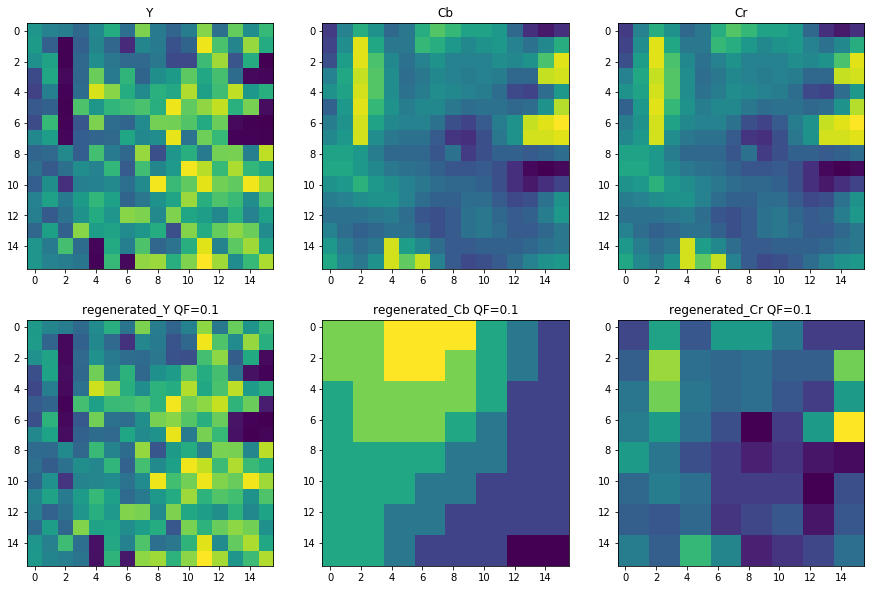

In [45]:
plt.figure(figsize=(15,10))
plt.subplot(234)
plt.title('regenerated_Y QF={}'.format(QF))
plt.imshow(regenerated_Y)
plt.subplot(231)
plt.title('Y')
plt.imshow(Y)
plt.subplot(235)
plt.title('regenerated_Cb QF={}'.format(QF))
plt.imshow(regenerated_Cb)
plt.subplot(232)
plt.title('Cb')
plt.imshow(Cr)
plt.subplot(236)
plt.title('regenerated_Cr QF={}'.format(QF))
plt.imshow(regenerated_Cr)
plt.subplot(233)
plt.title('Cr')
plt.imshow(Cr)
plt.show()

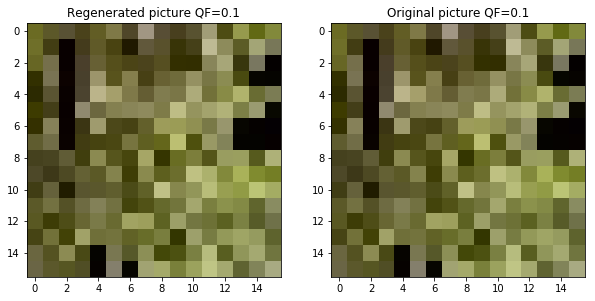

In [46]:
#regenerated = cv2.merge((regenerated_Y, regenerated_Cb, regenerated_Cr)).astype(np.uint8)
regenerated = cv2.merge((Y, Cb, Cr)).astype(np.uint8)
regenerated = cv2.cvtColor(regenerated,cv2.COLOR_YCR_CB2RGB)
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Regenerated picture QF={}'.format(QF))
plt.imshow(regenerated)
plt.subplot(122)
plt.title('Original picture QF={}'.format(QF))
plt.imshow(src)
plt.show()

(225, 225, 3)


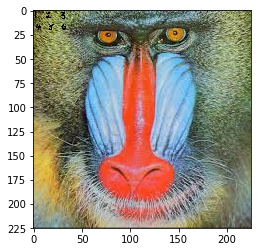

In [48]:
#img_name = 'Add.png'
img_name = './code/pics/baboon.jpg'
fullPic = plt.imread(img_name)
print(fullPic.shape)
pic = Frame(fullPic, QF=0.1)
plt.imshow(fullPic)

In [56]:
def compare_block(pos,QF):
    tmp = pic.getBlock(0,0)
    tmp1 = encode(tmp,QF)
    tmp2 = decode(tmp1,QF)
    tmp3 = cv2.merge((tmp2)).astype(np.uint8)
    tmp3 = cv2.cvtColor(tmp3,cv2.COLOR_YCR_CB2RGB)
    
    plt.subplot(pos)
    plt.title('Regenerated Picture QF={}'.format(QF))
    plt.imshow(tmp3)

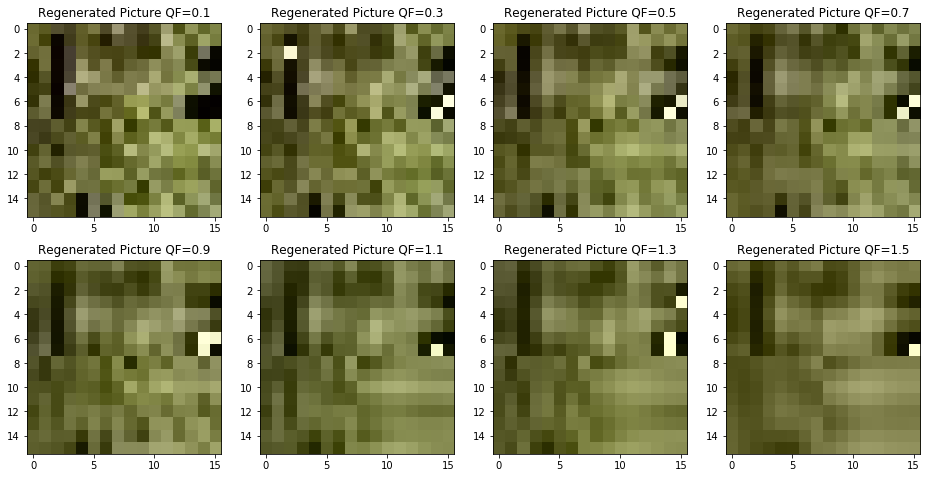

In [61]:
plt.figure(figsize=(16,8))
compare_block(241,0.1)
compare_block(242,0.3)
compare_block(243,0.5)
compare_block(244,0.7)
compare_block(245,0.9)
compare_block(246,1.1)
compare_block(247,1.3)
compare_block(248,1.5)
plt.show()